# Setup
* note for this file, to optimize for model performance, I tried to amplify the labels by 1000, so the numerical RMSE and MSE results will not be on the same scale as other models. R2, however, is on the same scale.


In [3]:
! pip install -q torch

In [4]:
! pip install -q accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 11.3 MB/s eta 0:00:00


In [5]:
! pip install -q transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.0
    Uninstalling huggingface-hub-0.19.0:
      Successfully uninstalled huggingface-hub-0.19.0


In [6]:
! pip install -q transformers

In [7]:
! pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00


In [27]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import h5py
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from datasets import Dataset
import math
from transformers import TrainingArguments, Trainer
import torch

In [9]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [64]:
TASK = 'current'
if TASK == 'current':
  LABEL = 'MONTHLY_RETURN'
else:
  LABEL = 'MONTHLY_RETURN_F1'

# Data Preprocessing for BERT

In [135]:
Xy_test = pd.read_csv('/content/gdrive/MyDrive/lazard/preprocessed_data/Xy_valBERT.csv') #test
Xy_train_all = pd.read_csv('/content/gdrive/MyDrive/lazard/preprocessed_data/Xy_trainBERT.csv')

In [136]:
Xy_test[LABEL] = Xy_test[LABEL] * 1000
Xy_train_all[LABEL] = Xy_train_all[LABEL] * 1000

In [137]:
BASE_MODEL = "distilbert-base-uncased"
LEARNING_RATE = 2e-5
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 10

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [138]:
# first, get the y_train and y_val, then later based on that I will get X_train and X_val
# Create empty lists to store data for each stock
Xy_train_list = []
Xy_val_list = []

# Group the data by 'security' column
grouped = Xy_train_all.groupby('security')

for security, data in grouped:
    # Sort the data by the time (date) column
    data = data.sort_values(by='date')

    # Calculate the index for the 70% point
    split_index = int(0.8 * len(data))

    # Split the data into training and validation sets
    Xy_train_stock, Xy_val_stock = data.iloc[:split_index], data.iloc[split_index:]

    # Append data for the current stock to the lists
    Xy_train_list.append(Xy_train_stock)
    Xy_val_list.append(Xy_val_stock)

# Concatenate the individual DataFrames for each stock
Xy_train = pd.concat(Xy_train_list)
Xy_val = pd.concat(Xy_val_list)

# Reset index for the final DataFrames
Xy_train.reset_index(drop=True, inplace=True)
Xy_val.reset_index(drop=True, inplace=True)

# Print the shapes of the resulting DataFrames
print("Xy_train shape:", Xy_train.shape)
print("Xy_val shape:", Xy_val.shape)

Xy_train shape: (26712, 6)
Xy_val shape: (6690, 6)


In [139]:
Xy_valds = Dataset.from_pandas(Xy_val)
Xy_trainds = Dataset.from_pandas(Xy_train)
Xy_testds = Dataset.from_pandas(Xy_test)

# Modeling

# Task: current MONTHLY_RETURN


In [140]:
def preprocess_function(examples):
    label = examples[LABEL]
    examples = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)

    # Change this to real number
    examples["label"] = float(label)
    return examples

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    single_squared_errors = ((logits - labels).flatten()**2).tolist()

    return {"mse": mse, "mae": mae, "r2": r2, "rmse":rmse}

class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0][:, 0]
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

def analyze(pred25_cur, TASK, mode):
    """
    generate prediction vs y_true plot
    save evaluation metrics to path.
    """
    # Iterate over each stock in the dictionary
    ses = pred25_cur['security'].unique()
    for security in ses:
        predictions = pred25_cur[pred25_cur['security'] == security]
        y_preds = predictions['y_preds']
        y = predictions['y']

        # Create a figure and axis
        fig, ax = plt.subplots()
        print(f'y vs y_pred: {y.shape} vs {y_preds.shape}')


        # Plot the real returns (y) in blue
        ax.plot(y, label='Real Returns', color='blue')

        # Plot the predicted returns (y_preds) in red
        ax.plot(y_preds, label='Predicted Returns', color='red')

        # Set axis labels and a legend
        ax.set_xlabel('Time')
        ax.set_ylabel('Returns')
        ax.set_title(f'{security} - Real vs. Predicted Returns')
        ax.legend()

        # Display or save the plot as needed
        plt.show()  # Use
        #plot_path = f'/content/gdrive/MyDrive/lazard/models/task_{TASK}/outputs/{mode}LSTM_{TASK}_lr0.01_nocomp.png'
        #plt.savefig(plot_path) # to save the plot to a file

    pred25_cur = pd.DataFrame(pred25_cur)
    analysis_path = f'/content/gdrive/MyDrive/lazard/models/task_{TASK}/outputs/{mode}BERT_{TASK}.csv'
    pred25_cur.to_csv(analysis_path)
    return pred25_cur




In [141]:
ds_cur = {"train": Xy_trainds, "validation": Xy_valds, "test": Xy_testds}

In [142]:
for split in ds_cur:
    ds_cur[split] = ds_cur[split].map(preprocess_function, remove_columns=['MONTHLY_RETURN','MONTHLY_RETURN_F1'])


Map:   0%|          | 0/26712 [00:00<?, ? examples/s]

Map:   0%|          | 0/6690 [00:00<?, ? examples/s]

Map:   0%|          | 0/18383 [00:00<?, ? examples/s]

In [143]:
ds_cur['validation'][0].keys()

dict_keys(['security', 'month', 'date', 'text', 'input_ids', 'attention_mask', 'label'])

In [144]:
training_args = TrainingArguments(
    output_dir=f"/content/gdrive/MyDrive/lazard/models/task_{TASK}/task_{TASK}_aggBERT",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="rmse",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

In [145]:

trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=ds_cur["train"],
    eval_dataset=ds_cur["validation"],
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Mse,Mae,R2,Rmse
1,9995.938000,43932.933594,43932.933594,129.949173,-0.247837,209.601852
2,5224.609500,37290.820312,37290.824219,121.472504,-0.059180,193.108322
3,1159.506900,34686.566406,34686.566406,110.610741,0.014789,186.243301
4,555.942200,35354.785156,35354.785156,109.647499,-0.004190,188.028687
5,350.291100,35308.617188,35308.617188,109.389404,-0.002879,187.905869
6,151.254200,35106.382812,35106.382812,108.771149,0.002865,187.366974
7,122.262100,35320.910156,35320.914062,109.985634,-0.003228,187.938599
8,104.180400,35170.152344,35170.148438,109.066231,0.001054,187.537064
9,77.971300,35486.617188,35486.617188,110.467903,-0.007935,188.378922
10,61.757200,35547.675781,35547.675781,110.334686,-0.009669,188.540909


TrainOutput(global_step=16700, training_loss=2124.7333839352546, metrics={'train_runtime': 2269.5283, 'train_samples_per_second': 117.698, 'train_steps_per_second': 7.358, 'total_flos': 1.769203024662528e+16, 'train_loss': 2124.7333839352546, 'epoch': 10.0})

# Evaluation

In [146]:
trainer.eval_dataset=ds_cur["test"]
trainer.evaluate()

{'eval_loss': 17119.87109375,
 'eval_mse': 17119.87109375,
 'eval_mae': 99.12346649169922,
 'eval_r2': -0.09414486422429369,
 'eval_rmse': 130.84292602539062,
 'eval_runtime': 55.6976,
 'eval_samples_per_second': 330.05,
 'eval_steps_per_second': 20.629,
 'epoch': 10.0}

In [147]:
import math

nb_batches = math.ceil(len(Xy_testds)/BATCH_SIZE)
y_preds = []

for i in range(nb_batches):
    input_texts = Xy_testds[i * BATCH_SIZE: (i+1) * BATCH_SIZE]["text"]
    input_labels = Xy_testds[i * BATCH_SIZE: (i+1) * BATCH_SIZE][LABEL]
    encoded = tokenizer(input_texts, truncation=True, padding="max_length", max_length=256, return_tensors="pt").to("cuda")
    y_preds += model(**encoded).logits.reshape(-1).tolist()

pd.set_option('display.max_rows', 500)



In [148]:
preds = pd.DataFrame([Xy_testds["security"], Xy_testds["date"] , Xy_testds["text"], Xy_testds[LABEL], y_preds], ['security' , 'date', "Text", "y", "y_preds"]).T

In [149]:
preds

,security,date,Text,y,y_preds
0,AMZN US Equity,2022-07-01,"AMZN US Equity 2022-07-01 65 Amazon.com, Inc. ...",270.595989,5.863134
1,AMZN US Equity,2022-07-01,AMZN US Equity 2022-07-01 -51 Fund lowered its...,270.595989,29.124033
2,AMZN US Equity,2022-07-01,AMZN US Equity 2022-07-01 -51 Bar Harbor Trust...,270.595989,17.663555
3,AMZN US Equity,2022-07-01,AMZN US Equity 2022-07-01 65 Bank of Kentucky ...,270.595989,14.386951
4,AMZN US Equity,2022-07-01,AMZN US Equity 2022-07-01 -51 Charter Trust Co...,270.595989,21.297264
...,...,...,...,...,...
18378,YUM US Equity,2023-09-28,YUM US Equity 2023-09-28 36 Taco Bell Corp.: B...,-34.317514,-54.736099
18379,YUM US Equity,2023-09-28,YUM US Equity 2023-09-28 0 The Habit Burger Gr...,-34.317514,-54.6889
18380,YUM US Equity,2023-09-28,YUM US Equity 2023-09-28 0 The Habit Burger Gr...,-34.317514,-54.6889
18381,YUM US Equity,2023-09-28,YUM US Equity 2023-09-28 0 The Habit Burger Gr...,-34.317514,-54.6889


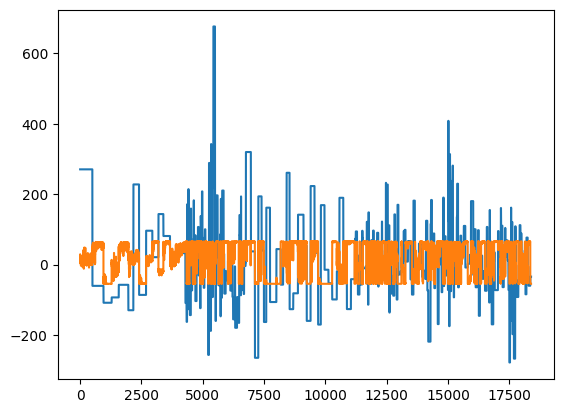

In [150]:
plt.plot(preds['y'])
plt.plot(preds['y_preds'])

In [151]:
preds['security'].unique()

array(['AMZN US Equity', 'APTV US Equity', 'AZO US Equity',
       'BKNG US Equity', 'CCL US Equity', 'CMG US Equity', 'DG US Equity',
       'EBAY US Equity', 'F US Equity', 'GM US Equity', 'HD US Equity',
       'HLT US Equity', 'LOW US Equity', 'LVS US Equity', 'MAR US Equity',
       'MCD US Equity', 'NKE US Equity', 'ORLY US Equity',
       'RCL US Equity', 'ROST US Equity', 'SBUX US Equity',
       'TGT US Equity', 'TJX US Equity', 'VFC US Equity', 'YUM US Equity'],
      dtype=object)

In [152]:
def analyze(pred25_cur, TASK, mode):
    """
    generate prediction vs y_true plot
    save evaluation metrics to path.
    """
    # Iterate over each stock in the dictionary
    ses = pred25_cur['security'].unique()
    collection = {}
    for security in ses:
        predictions = pred25_cur[pred25_cur['security'] == security]
        y_preds = predictions['y_preds']
        y = predictions['y']

        # Create a figure and axis
        fig, ax = plt.subplots()
        print(f'y vs y_pred: {y.shape} vs {y_preds.shape}')


        # Plot the real returns (y) in blue
        ax.plot(y, label='Real Returns', color='blue')

        # Plot the predicted returns (y_preds) in red
        ax.plot(y_preds, label='Predicted Returns', color='red')

        # Set axis labels and a legend
        ax.set_xlabel('Time')
        ax.set_ylabel('Returns')
        ax.set_title(f'{security} - Real vs. Predicted Returns')
        ax.legend()

        # Display or save the plot as needed
        plt.show()  # Use
        #plot_path = f'/content/gdrive/MyDrive/lazard/models/task_{TASK}/outputs/{mode}LSTM_{TASK}_lr0.01_nocomp.png'
        #plt.savefig(plot_path) # to save the plot to a file
        r_squared = r2_score(y, y_preds)
        mse = mean_squared_error(y, y_preds)
        rmse = np.sqrt(mse)
        pred_org = {'r_squared':r_squared, 'rmse':rmse,'mse':mse}
        collection[security] = pred_org


    collection = pd.DataFrame(collection)
    analysis_path = f'/content/gdrive/MyDrive/lazard/models/task_{TASK}/outputs/{mode}BERT_{TASK}.csv'
    collection.to_csv(analysis_path)
    return collection




y vs y_pred: (4290,) vs (4290,)


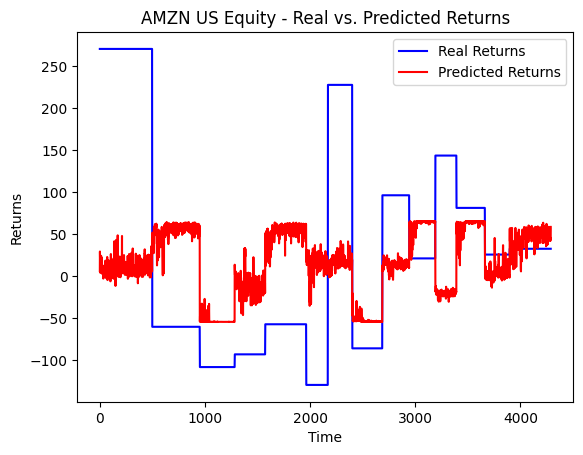

y vs y_pred: (276,) vs (276,)


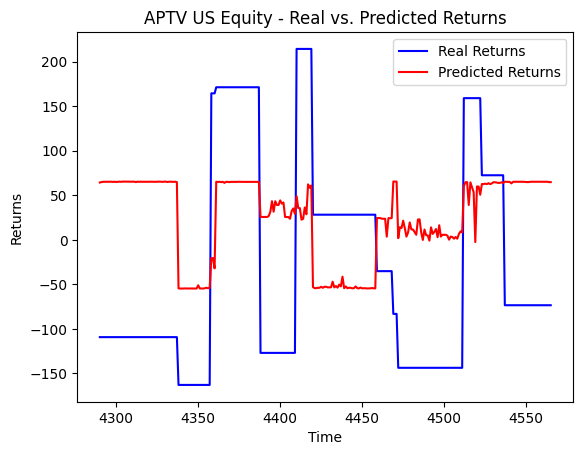

y vs y_pred: (234,) vs (234,)


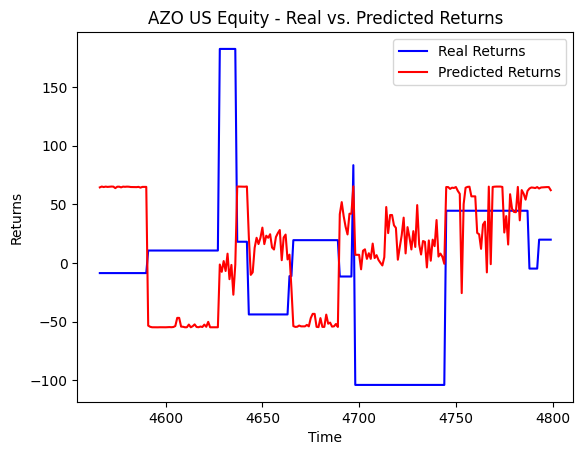

y vs y_pred: (348,) vs (348,)


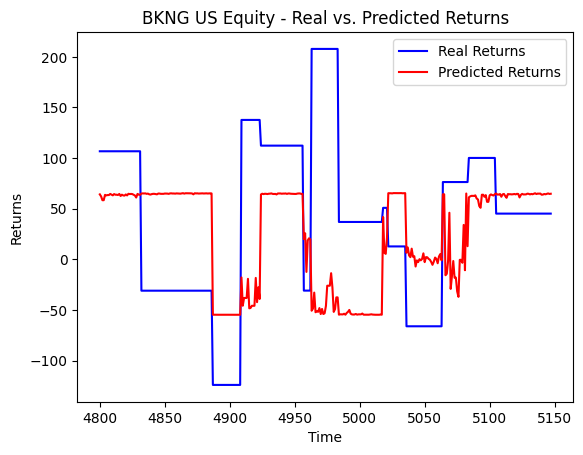

y vs y_pred: (387,) vs (387,)


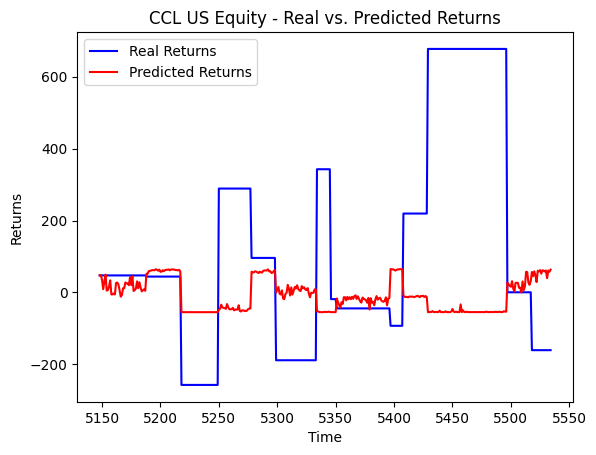

y vs y_pred: (407,) vs (407,)


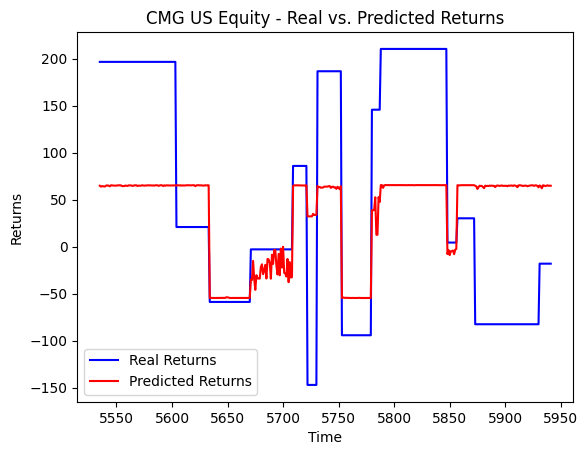

y vs y_pred: (453,) vs (453,)


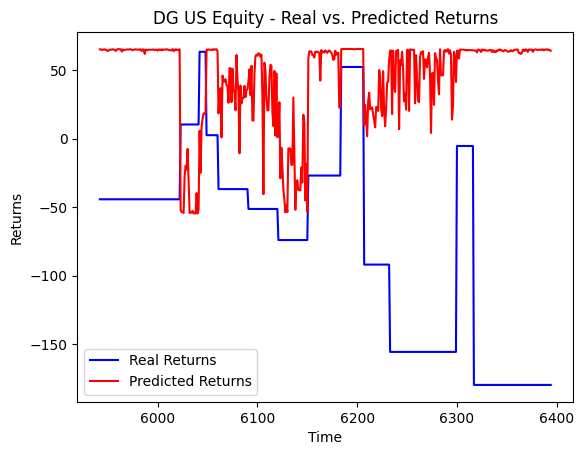

y vs y_pred: (360,) vs (360,)


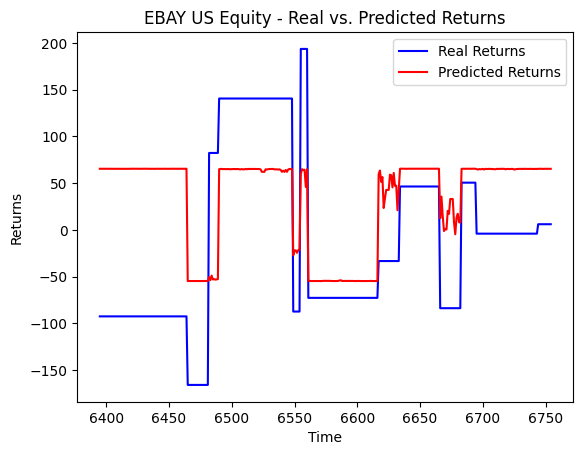

y vs y_pred: (2124,) vs (2124,)


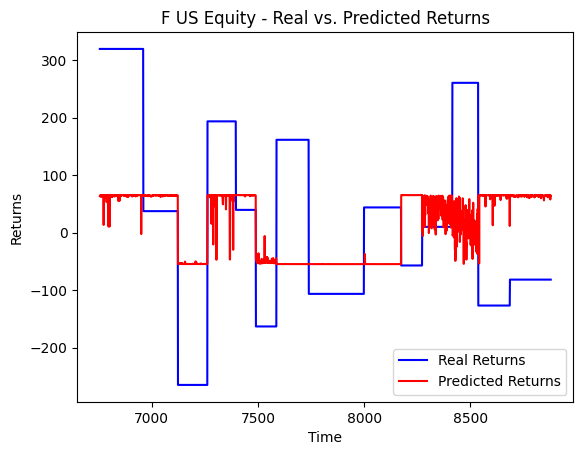

y vs y_pred: (2159,) vs (2159,)


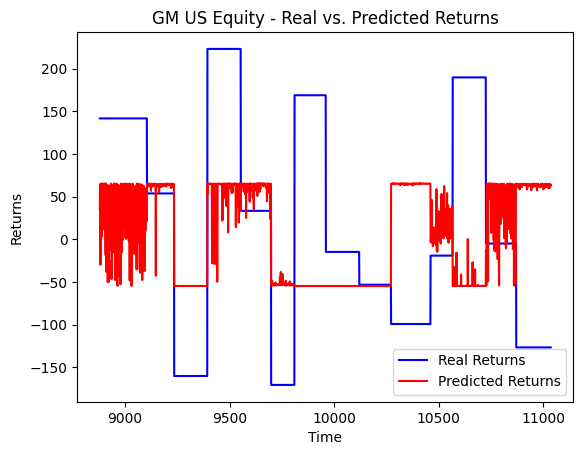

y vs y_pred: (594,) vs (594,)


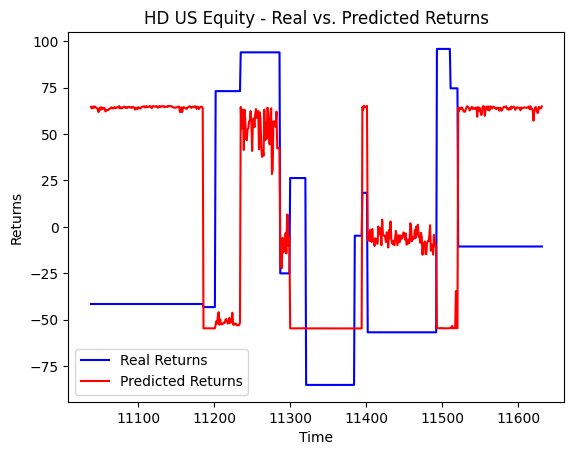

y vs y_pred: (308,) vs (308,)


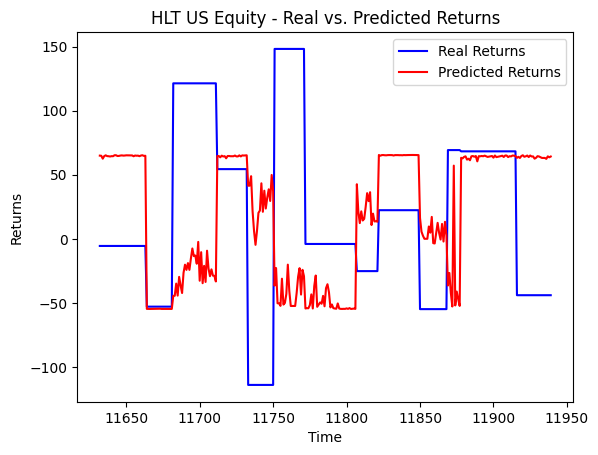

y vs y_pred: (457,) vs (457,)


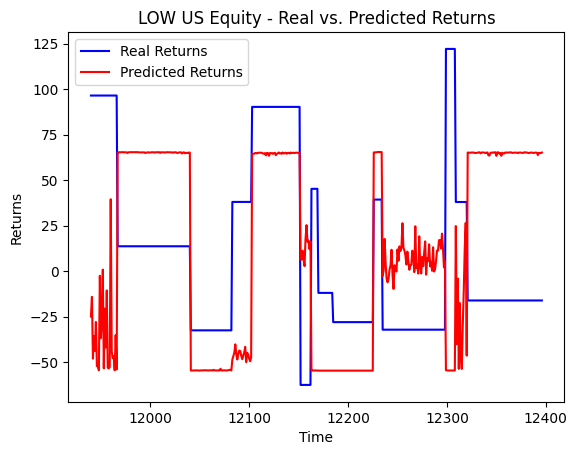

y vs y_pred: (295,) vs (295,)


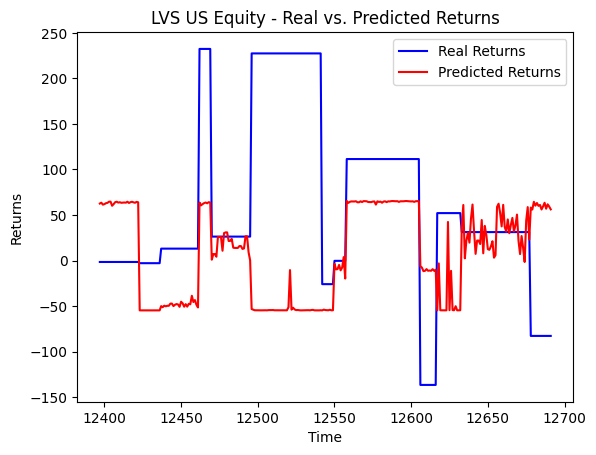

y vs y_pred: (670,) vs (670,)


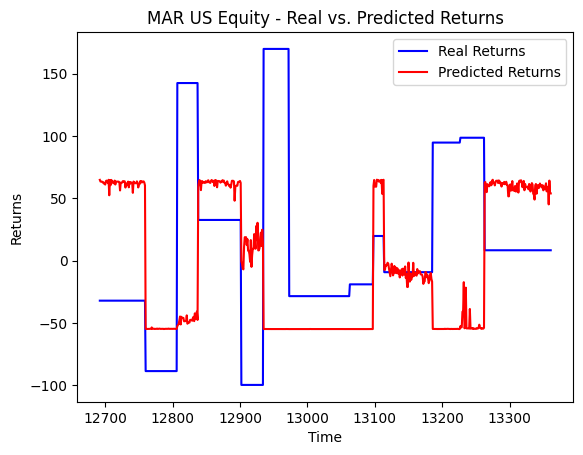

y vs y_pred: (736,) vs (736,)


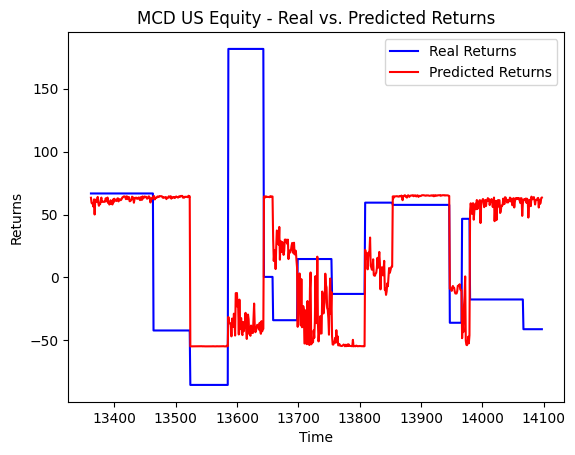

y vs y_pred: (664,) vs (664,)


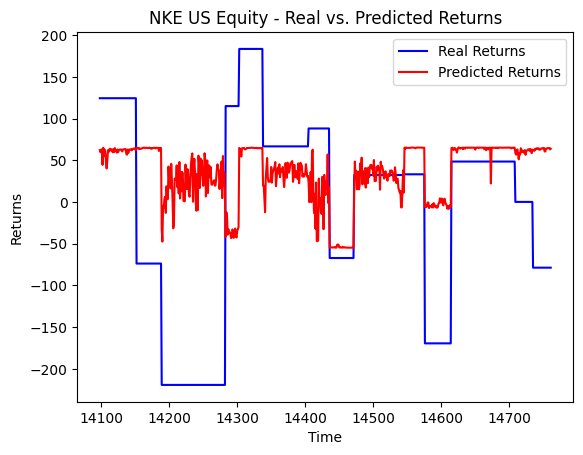

y vs y_pred: (186,) vs (186,)


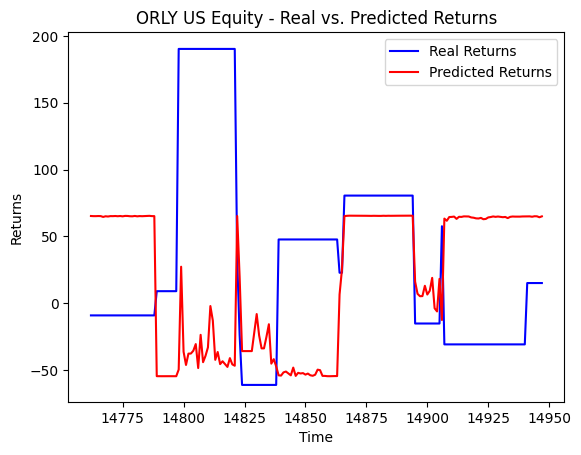

y vs y_pred: (296,) vs (296,)


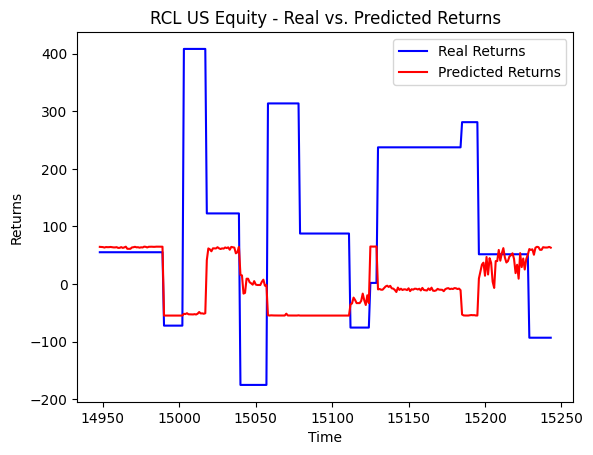

y vs y_pred: (394,) vs (394,)


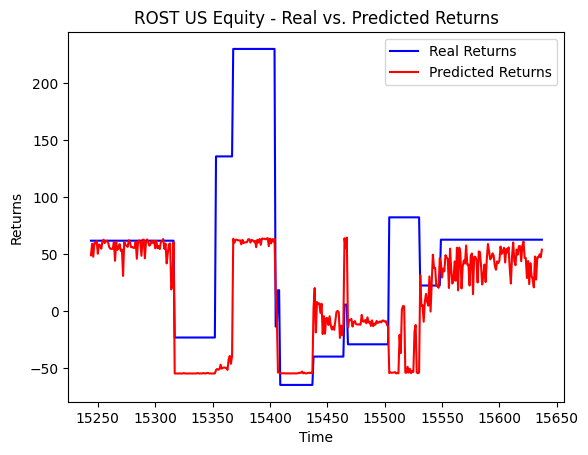

y vs y_pred: (798,) vs (798,)


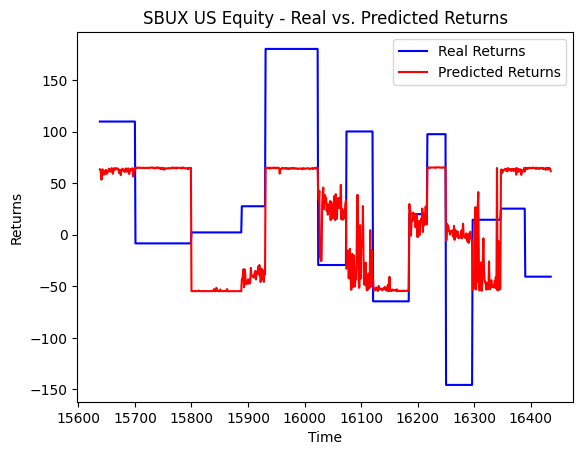

y vs y_pred: (596,) vs (596,)


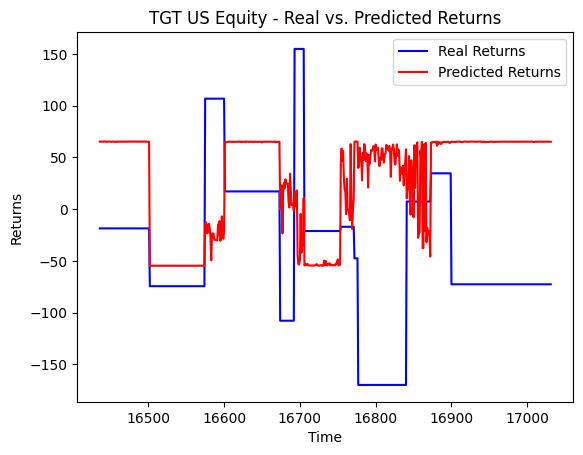

y vs y_pred: (390,) vs (390,)


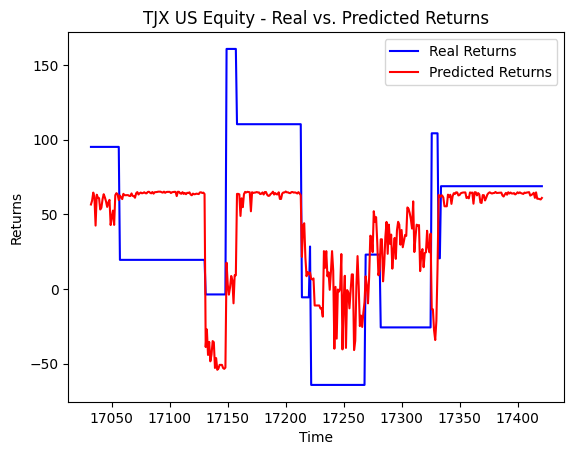

y vs y_pred: (363,) vs (363,)


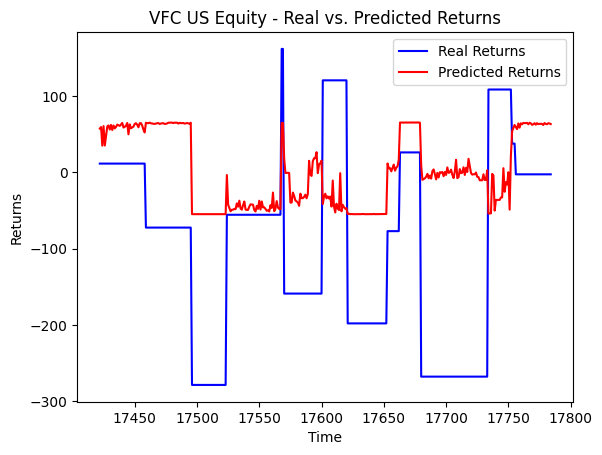

y vs y_pred: (598,) vs (598,)


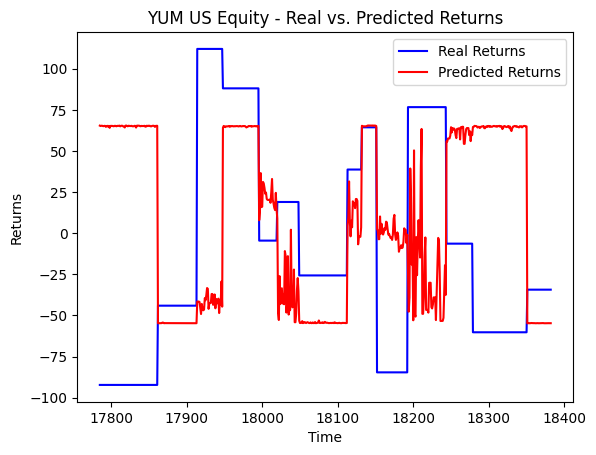

,AMZN US Equity,APTV US Equity,AZO US Equity,BKNG US Equity,CCL US Equity,CMG US Equity,DG US Equity,EBAY US Equity,F US Equity,GM US Equity,...,MCD US Equity,NKE US Equity,ORLY US Equity,RCL US Equity,ROST US Equity,SBUX US Equity,TGT US Equity,TJX US Equity,VFC US Equity,YUM US Equity
r_squared,-0.029113,-0.260029,-0.653754,-0.329782,-0.342970,0.234946,-3.242936,-0.034223,0.089562,-0.149955,...,-0.490054,-0.028613,-0.985896,-0.842369,0.104919,0.066920,-1.571465,0.258466,-0.425925,-0.988040
rmse,128.636297,133.746197,82.037832,95.321891,345.566769,107.017015,147.143536,93.648366,156.752297,136.066864,...,82.379275,119.983608,104.427358,204.250650,73.838683,80.389894,113.212365,50.886786,152.528328,92.182066
mse,16547.296997,17888.045248,6730.205896,9086.262959,119416.391642,11452.641515,21651.220113,8770.016494,24571.282626,18514.191576,...,6786.344972,14396.066233,10905.073184,41718.328118,5452.151180,6462.535022,12817.039612,2589.464996,23264.890692,8497.533343


In [153]:
ana = analyze(preds, TASK, 'agg')
ana

In [154]:
trainer.save_model(f"/content/gdrive/MyDrive/lazard/models/task_{TASK}/task_{TASK}_aggBERT/model_epoch{EPOCHS}_amplify1000")